# README

### Overview
This project is a quantum circuit simulator implemented in Python. It reads quantum assembly language (QASM) files, simulates the corresponding quantum circuits, measures execution times, and generates plots to visualize performance metrics such as execution time against the number of qubits and gates.

### Features

- Quantum Gate Definitions: Implements fundamental quantum gates like Hadamard (H), Pauli-X (X), T, T-dagger, and Controlled-NOT (CX) as unitary matrices.

- Quantum Circuit Simulation: Simulates quantum circuits using a state vector representation with big-endian ordering.

- QASM Parsing: Parses QASM files to construct quantum circuits dynamically.

- Execution Time Measurement: Measures the execution time of quantum circuit simulations.

- Data Visualization: Generates plots to visualize execution times against benchmark names, the number of qubits, and the number of gates.


### Requirements

- Python 3.x
- NumPy
- Matplotlib
- Collections (for Counter)
- Regular Expressions (re)
- Time module (time)
- OS module (os)

### Usage

The script will:

- Parse each QASM file and construct the corresponding quantum circuit.
- Simulate the execution of each circuit.
- Measure and print the execution time for each benchmark.
- Generate and display plots:
    - Bar Chart: Execution time vs. benchmark names.
    - Scatter Plot: Execution time vs. number of qubits.
    - Scatter Plot: Execution time vs. number of gates.


## Core Implementation

In [111]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from collections import Counter
import re

In [112]:
# Define quantum gates as unitary matrices
H = 1 / np.sqrt(2) * np.array([[1, 1], [1, -1]])  # H gate
X = np.array([[0, 1], [1, 0]])  # X gate
T = np.array([[1, 0], [0, np.exp(1j * np.pi / 4)]])  # T gate
T_dagger = np.conjugate(T.T)  # T-dagger gate
CX = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 0, 1],
              [0, 0, 1, 0]]) 

In [113]:
class QuantumCircuit:
    """
    A class to represent a quantum circuit simulator with big endian state vector.
    
    Attributes:
        num_qubits (int): Number of qubits in the circuit.
        state (np.ndarray): The state vector representing the quantum state in big endian format.
        gates (list): A list of gates to be applied to the circuit.
    """
    def __init__(self, num_qubits):
        self.num_qubits = num_qubits
        self.state = np.zeros(2**num_qubits, dtype=complex)
        # Initialize the state |0...0⟩ in big endian format
        self.state[0] = 1
        self.gates = []  # to be appended

    def apply_gate(self, gate, target, control=None):
        gate_lower = gate.lower()
        if gate_lower == 'cx' and control is not None:
            self.state = self.apply_cx_gate(self.state, control, target)
        else:
            U = {'h': H, 'x': X, 't': T, 'tdg': T_dagger}.get(gate_lower)
            if U is None:
                raise ValueError(f"Unsupported gate: {gate}")
            if control is None:
                self.state = self.apply_single_qubit_gate(self.state, U, target)  # Update state vector
            else:
                self.state = self.apply_controlled_gate(self.state, U, control, target)  # Update state vector

    def apply_single_qubit_gate(self, state, U, target):
        """
        Applies a single-qubit gate to the specified target qubit (big endian).
        
        Args:
            state (np.ndarray): The current state vector of the quantum circuit.
            U (np.ndarray): The unitary matrix representing the gate.
            target (int): The index of the target qubit (0 is the most significant qubit).
        
        Returns:
            np.ndarray: The updated state vector after applying the gate.
        """
        num_qubits = self.num_qubits
        N = len(state)  # N = number of possible states
        indices = np.arange(N)
        # Adjust the target index for big endian format
        adjusted_target = num_qubits - 1 - target
        qubit_mask = 1 << adjusted_target  # Left shift 1 by 'adjusted_target' positions
        idx0 = indices[(indices & qubit_mask) == 0]  # Indices where the target qubit is |0⟩
        idx1 = idx0 + qubit_mask  # Indices where the target qubit is |1⟩
        a = state[idx0].copy()
        b = state[idx1].copy()
        # Apply gate matrix to paired amplitudes
        state[idx0] = U[0, 0] * a + U[0, 1] * b
        state[idx1] = U[1, 0] * a + U[1, 1] * b
        return state

    def apply_cx_gate(self, state, control, target):
        """
        Applies a Controlled-X (CNOT) gate to the quantum circuit (big endian).
        
        Args:
            state (np.ndarray): The current state vector of the quantum circuit.
            control (int): The index of the control qubit (0 is the most significant qubit).
            target (int): The index of the target qubit (0 is the most significant qubit).
        
        Returns:
            np.ndarray: The updated state vector after applying the CNOT gate.
        """
        num_qubits = self.num_qubits
        N = len(state)
        indices = np.arange(N)
        # Adjust indices for big endian format
        adjusted_control = num_qubits - 1 - control
        adjusted_target = num_qubits - 1 - target
        control_mask = 1 << adjusted_control
        target_mask = 1 << adjusted_target
        # Indices where control qubit is |1⟩ and target qubit is |0⟩
        idx_control1_target0 = indices[((indices & control_mask) != 0) & ((indices & target_mask) == 0)]
        idx_control1_target1 = idx_control1_target0 + target_mask
        # Swap the amplitudes of target qubit when control is |1⟩
        temp = state[idx_control1_target0].copy()
        state[idx_control1_target0] = state[idx_control1_target1]
        state[idx_control1_target1] = temp
        return state

    def run(self):
        """Execute gates in the quantum circuit in the order they were added."""
        for gate, target, control in self.gates:
            self.apply_gate(gate, target, control)

    def measure_all(self):
        """
        Performs a single measurement of all qubits in the quantum circuit (big endian).
        
        Returns:
            str: A binary string representing the measured state of all qubits.
        """
        probabilities = np.abs(self.state) ** 2
        result = np.random.choice(range(len(self.state)), p=probabilities)
        measured_state = bin(result)[2:].zfill(self.num_qubits)
        # The measured_state is already in big endian format
        return measured_state

    def measure_all_shots(self, num_shots=1024):
        """
        Performs multiple measurements (shots) of all qubits and returns the counts of each observed state (big endian).
        
        Args:
            num_shots (int, optional): The number of measurements to perform. Defaults to 1024.
        
        Returns:
            dict: A dictionary mapping each observed binary state to its count.
        """
        probabilities = np.abs(self.state) ** 2
        results = np.random.choice(range(len(self.state)), size=num_shots, p=probabilities)
        bitstrings = [bin(result)[2:].zfill(self.num_qubits) for result in results]
        counts = Counter(bitstrings)
        return dict(sorted(counts.items()))

In [114]:
# Parse QASM file
def parse_qasm(qasm_string):
    """
    Parses a QASM file and constructs a QuantumCircuit object based on the parsed gates.

    Args:
        qasm_str (str): string of the qasm file

    Returns:
        QuantumCircuit: The constructed quantum circuit with gates applied.
        int: The total number of qubits in the circuit.
        int: The total number of gate operations parsed.
    """
    #find effective number of qubits
    qubits_used = set()
    lines = qasm_string.strip().split('\n')
    gate_lines = lines[4:]#Skip first 4 lines (as they are not gates info)
    for i in gate_lines:
        gates = re.findall(r'\bq\[(\d+)\]', i)#extract the register number
        for qubit in gates:
            qubits_used.add(int(qubit))
    effective_qubits = max(qubits_used) + 1 # find the max register number, +1 because index starts from 0

    #create a circuit
    circuit = QuantumCircuit(effective_qubits)
    
    num_line = 0 #total lines/gates indicated by the file
    # Parse each gate operation and append it to the circuit's gate list
    for line in qasm_string.splitlines():
        num_line+= 1 # Increment the gate operation counter
        line = line.strip()

        if line.startswith('h '): # Check if the line defines a Hadamard gate
            qubit = int(line.split('[')[1].split(']')[0])# Extract the target qubit index
            circuit.gates.append(('h', qubit, None))# Append the gate as a tuple (gate_type, target, control)

        elif line.startswith('cx '):  # CNOT gate
            # Remove parentheses and semicolon, then split the line into parts
            parts = line.replace(')', '').replace('(', '').replace(';', '').split()
            control = int(parts[1].split('[')[1].split(']')[0])  # Extract the control qubit index
            target = int(parts[1].split(',q[')[1].split(']')[0])  # Extract the target qubit index
            circuit.gates.append(('cx', target, control))  # Append as ('cx', target, control)

        elif line.startswith('t '):  # Check if the line defines a T gate
            qubit = int(line.split('[')[1].split(']')[0])
            circuit.gates.append(('t', qubit, None))
        elif line.startswith('tdg '): # Check if the line defines a T-dagger gate
            qubit = int(line.split('[')[1].split(']')[0])
            circuit.gates.append(('tdg', qubit, None))
        elif line.startswith('x'):
            qubit = int(line.split('[')[1].split(']')[0])
            circuit.gates.append(('x', qubit, None))

    return circuit, effective_qubits, num_line # Return the circuit, total qubits, and number of gate operations

In [115]:
def simulate(string): #this is the function for compare_simulators.py to run the tests on benchmarks
    """
    Simulates a quantum circuit defined in a QASM file and returns the final state vector.

    Args:
        string (str): the string converted from qasm file

    Returns:
        np.ndarray: The final state vector of the quantum circuit.
    """

    # Parse the QASM file to get the quantum circuit
    circuit, num_qubits, num_gates = parse_qasm(string)

    # Execute the quantum circuit
    circuit.run()
    
    # Return the final state vector
    return circuit.state

## Example Usage

In [116]:
#Run the circuit once:
with open('benchmarks/miller_11.qasm', "r") as f:
        qasm_string = f.read()
circuit1 = parse_qasm(qasm_string)[0]
circuit1.run()
print(f'miller_11.qsam:{circuit1.measure_all()}')


with open('benchmarks/one-two-three-v3_101.qasm', "r") as f:
        qasm_string = f.read()
circuit2 = parse_qasm(qasm_string)[0]
circuit2.run()
print(f'one-two-three-v3_101:{circuit2.measure_all()}')


with open('benchmarks/decod24-v2_43.qasm', "r") as f:
        qasm_string = f.read()
circuit3 = parse_qasm(qasm_string)[0]
circuit3.run()
print(f'decod24-v2_43.qasm:{circuit3.measure_all()}')

miller_11.qsam:000
one-two-three-v3_101:11000
decod24-v2_43.qasm:0001


In [117]:
#Run the circuit with 1024 shots:
with open('benchmarks/rd84_142.qasm',"r") as f:
    string_rd84 = f.read()
circuit_rd84 = parse_qasm(string_rd84)[0]
circuit_rd84.run()
print(f'rd84_142:{circuit_rd84.measure_all_shots(1024)}')

with open('benchmarks/wim_266.qasm', "r") as f:
    string_wim = f.read()
circuit_wim = parse_qasm(string_wim)[0]
circuit_wim.run()
print(f'wim_266:{circuit_wim.measure_all_shots(1024)}')

with open('benchmarks/squar5_261.qasm') as f:
    string_squar5 = f.read()  
circuit_squar5  = parse_qasm(string_squar5)[0]
circuit_squar5.run()
print(f'squar5_261:{circuit_squar5.measure_all_shots(1024)}')

rd84_142:{'000000000000000': 1024}
wim_266:{'11011111111': 1024}
squar5_261:{'0000000011011': 1024}


## Execution Time Plots

In [ ]:
def plot_execution_times_and_qubits(qasm_strings, benchmark_names, output_base='execution_plot'):
    """
    Runs quantum circuits from QASM strings, measures execution times,
    and plots execution times against benchmark names, number of qubits,
    and number of gates.
    
    Parameters:
        qasm_strings (list of str): List of QASM code strings.
        benchmark_names (list of str): List of benchmark names corresponding to the QASM strings.
        output_base (str): Base name for output plot files.
    """    
    # Initialize lists to store values
    execution_times = []
    num_qubits = []
    num_gates = []
    
    for qasm_str, benchmark_name in zip(qasm_strings, benchmark_names):
        # Parse the QASM string
        circuit, nq, ng = parse_qasm(qasm_str)
        if circuit is None:
            print(f"Skipping benchmark {benchmark_name} due to parsing error.")
            continue
        num_qubits.append(nq)
        num_gates.append(ng)
        print(f"Parsed {benchmark_name}: {nq} qubits, {ng} gates")
        
        # Measure the execution time
        start_time = time.perf_counter()
        circuit.run() if hasattr(circuit, 'run') else None  # Placeholder
        end_time = time.perf_counter()
        
        elapsed_time = end_time - start_time
        execution_times.append(elapsed_time)
        print(f"Executed {benchmark_name} in {elapsed_time:.4f} seconds")

    # 1. Bar Chart: Execution Time vs Benchmark Names
    plt.figure(figsize=(12, 6))  # Initialize a new figure
    bars = plt.bar(benchmark_names, execution_times, color='skyblue')
    plt.xlabel('Benchmark QASM Files')
    plt.ylabel('Execution Time (seconds)')
    plt.title('Quantum Circuit Execution Times')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    
    # Annotate bars with execution times
    for bar, time_val in zip(bars, execution_times):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height,
                 f'{time_val:.4f}', va='bottom', ha='center', fontsize=8)
    plt.tight_layout()
    
    # Save the bar chart
    bar_chart_filename = f"{output_base}_bar_chart.png"
    plt.savefig(bar_chart_filename)
    plt.show()  # Display the bar chart
    
    # 2. Scatter Plot: Execution Time vs Number of Qubits
    plt.figure(figsize=(10, 7))  # Initialize a new figure
    plt.scatter(num_qubits, execution_times, color='coral', marker='o')
    plt.xlabel('Number of Qubits')
    plt.ylabel('Execution Time (seconds)')
    plt.title('Execution Time vs Number of Qubits')
    # Add a trend line
    if len(num_qubits) > 1:
        z = np.polyfit(num_qubits, execution_times, 1)
        p = np.poly1d(z)
        # Sort the data for a proper trend line
        sorted_indices = np.argsort(num_qubits)
        sorted_qubits = np.array(num_qubits)[sorted_indices]
        sorted_times = p(sorted_qubits)
        plt.plot(sorted_qubits, sorted_times, "g--")
    plt.tight_layout()
    
    # Save the scatter plot
    scatter_qubits_filename = f"{output_base}_scatter_qubits.png"
    plt.savefig(scatter_qubits_filename)
    plt.show()  # Display the scatter plot
    
    # 3. Scatter Plot: Execution Time vs Number of Gates (Lines)
    plt.figure(figsize=(10, 7))  # Initialize a new figure
    plt.scatter(num_gates, execution_times, color='blue', marker='^')
    plt.xlabel('Number of Gates')
    plt.ylabel('Execution Time (seconds)')
    plt.title('Execution Time vs Number of Gates')
    
    # Add a trend line
    if len(num_gates) > 1:
        z = np.polyfit(num_gates, execution_times, 1)
        p = np.poly1d(z)
        # Sort the data for a proper trend line
        sorted_indices = np.argsort(num_gates)
        sorted_gates = np.array(num_gates)[sorted_indices]
        sorted_times = p(sorted_gates)
        plt.plot(sorted_gates, sorted_times, "g--")
    
    plt.tight_layout()
    
    # Save the scatter plot
    scatter_gates_filename = f"{output_base}_scatter_gates.png"
    plt.savefig(scatter_gates_filename)
    plt.show()  # Display the scatter plot

Parsed miller_11.qasm: 3 qubits, 54 gates
Executed miller_11.qasm in 0.0007 seconds
Parsed decod24-v2_43.qasm: 4 qubits, 56 gates
Executed decod24-v2_43.qasm in 0.0006 seconds
Parsed one-two-three-v3_101.qasm: 5 qubits, 74 gates
Executed one-two-three-v3_101.qasm in 0.0009 seconds
Parsed hwb5_53.qasm: 6 qubits, 1340 gates
Executed hwb5_53.qasm in 0.0135 seconds
Parsed alu-bdd_288.qasm: 7 qubits, 88 gates
Executed alu-bdd_288.qasm in 0.0008 seconds
Parsed f2_232.qasm: 8 qubits, 1210 gates
Executed f2_232.qasm in 0.0128 seconds
Parsed con1_216.qasm: 9 qubits, 958 gates
Executed con1_216.qasm in 0.0114 seconds
Parsed mini_alu_305.qasm: 10 qubits, 177 gates
Executed mini_alu_305.qasm in 0.0025 seconds
Parsed wim_266.qasm: 11 qubits, 990 gates
Executed wim_266.qasm in 0.0205 seconds
Parsed cm152a_212.qasm: 12 qubits, 1225 gates
Executed cm152a_212.qasm in 0.0398 seconds
Parsed squar5_261.qasm: 13 qubits, 1997 gates
Executed squar5_261.qasm in 0.0994 seconds
Parsed sym6_316.qasm: 14 qubits, 

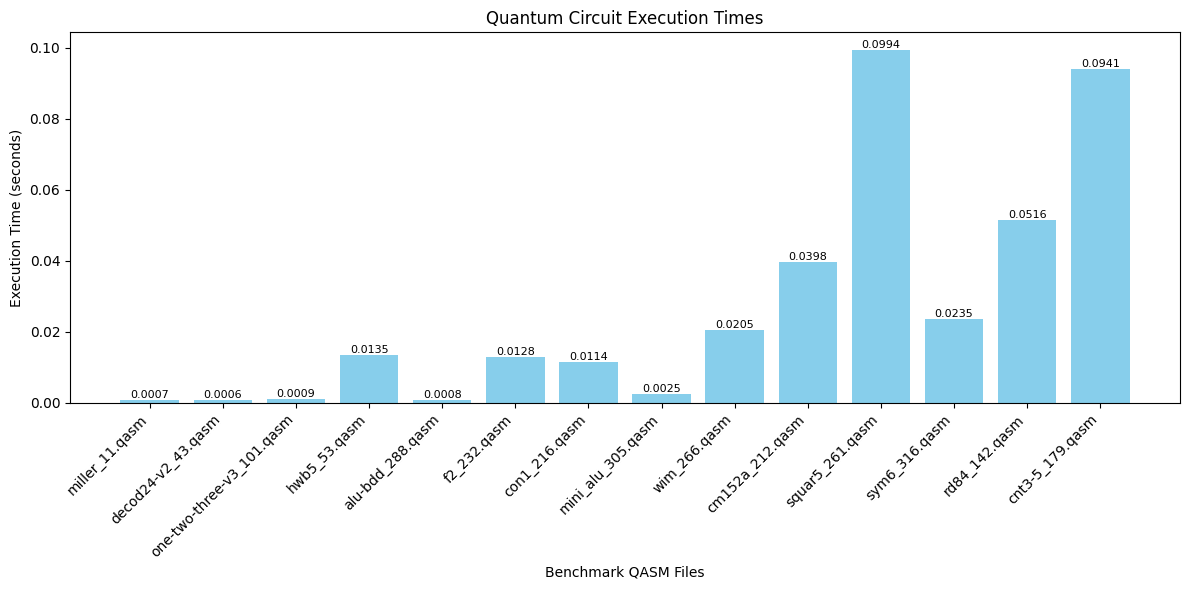

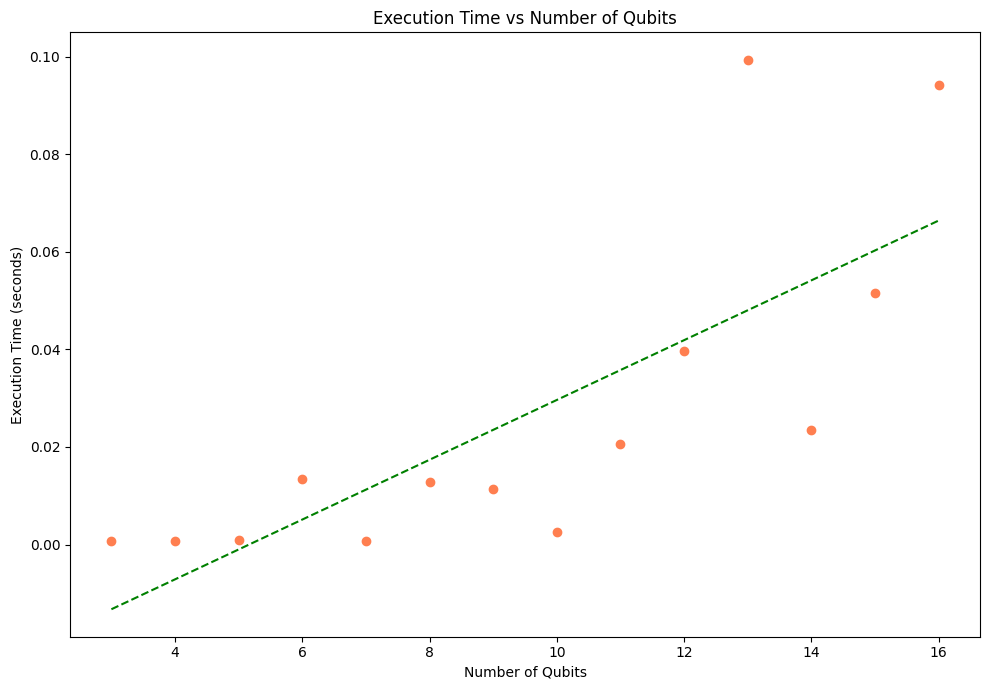

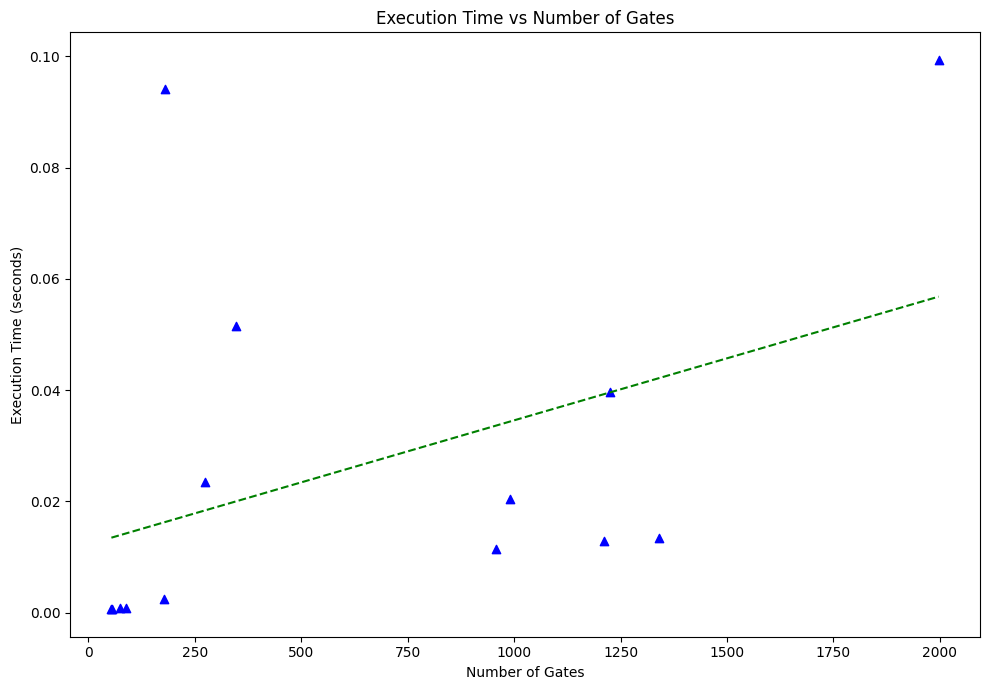

In [119]:
if __name__ == "__main__":
    qasm_files = [
        'benchmarks/miller_11.qasm',
        'benchmarks/decod24-v2_43.qasm',
        'benchmarks/one-two-three-v3_101.qasm',
        'benchmarks/hwb5_53.qasm',
        'benchmarks/alu-bdd_288.qasm',
        'benchmarks/f2_232.qasm',
        'benchmarks/con1_216.qasm',
        'benchmarks/mini_alu_305.qasm',
        'benchmarks/wim_266.qasm',
        'benchmarks/cm152a_212.qasm',
        'benchmarks/squar5_261.qasm',
        'benchmarks/sym6_316.qasm',
        'benchmarks/rd84_142.qasm',
        'benchmarks/cnt3-5_179.qasm'
    ]
    
    qasm_strings = []
    benchmark_names = []
    
    for file in qasm_files:
        if not os.path.isfile(file):
            print(f"File not found: {file}. Skipping.")
            continue
        with open(file, 'r') as f:
            qasm_str = f.read()
            qasm_strings.append(qasm_str)
            benchmark_names.append(os.path.basename(file))
    
    plot_execution_times_and_qubits(qasm_strings, benchmark_names)

## Conclusion

From the execution time plots we can see there is strong positive correlation between no.qubits/no.gates and execution time. In general, greater the number of qubits and gates involved, the longer it takes for the simulator to run.